# How do I fit 2D data?

In this particular case we are talking about image data where we have a 2D array of pixels and we want to describe the images created. We can also try fitting general `(x0, x1, y)` values - where `x0` and `x1` are the independent axes (i.e. coordinates) and y the dependent axis (i.e. data to fit) - but that's a lot harder to visualize.

# Why not 1D?

Before bothering with a 2D fit I strongly suggest you try  1D fit to the radial profile - it lets you check whether a model makes sense and is generally a lot easier and quicker to fit. However, you do have to fix the center of the profile, and miss out on asymmetric data, so you may have to go full 2D.

# A note on notebooks

Sherpa uses the [ds9](https://ds9.si.edu/) imaging tool to visualize imaging data. This is great, but it's not well-integrated into a Jupyter notebook, as it involves a separate process (i.e. is not captured within the notebook). So we are going to have to improvise (and if you find it an imposition please let us know as it's an area I want to work on but I need community suport; even better if you want to contribute to Sherpa ;-).

# What do we not talk about?

There's no discussion of coordinate systems: PHA data lets you fit in `channel`, `energy`, or `wavelength` space and for images we can use the `logical`, `physical`, or `wcs` systems (although I strongly discourage fitting in WCS coordinates).

There's limited discussion of filtering the data.

There's no discussion of including a PSF term to allow you to recover the true physical size of an object.

# What data are we fitting?

For this notebook let's simulate an image. It lets me show off simulating a data set **and** ends up with a much-easier-do-describe analysis session, as real data is tricky!

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sherpa.astro.ui import *

In [2]:
# We are using random numbers so, to make this notebook repeatable, we fix the seed for the random generator

np.random.seed(999)  # my top-secret seed; please don't use

Let's create a grid with x0=1 to 50 and x1=1 to 40, thanks to the [NumPy mgrid](https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html) function. I've purposefully chosen a rectangular grid as we unfortunately switch between FORTRAN/FITS indexing (x0, x1) and C indexing (x1, x0) in this process.

In [3]:
x1, x0 = np.mgrid[1:41, 1:51]
print(x0.shape)
print(x1.shape)

(40, 50)
(40, 50)


In [4]:
x0[0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [5]:
x1[:, 0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

The model is going to include a "blob" of emission from a [beta2d](https://cxc.cfa.harvard.edu/sherpa/ahelp/beta2d.html) model - often used to describe the X-ray emission from galaxy clusters - and a sloped background component (created using the [polynom2d](https://cxc.cfa.harvard.edu/sherpa/ahelp/polynom2d.html) model).

In [6]:
true_model = beta2d.true_blob + polynom2d.true_bgnd

In [7]:
# Set up the background
#
true_bgnd

<Polynom2D model instance 'polynom2d.true_bgnd'>

In [8]:
true_bgnd.c = 10
true_bgnd.cx1 = -0.1
true_bgnd.cy1 = 0.2

We can manually evaluate a model to see whether it makes sense. Note that the coordinates have to be 1D, hence the [flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) calls, and the need to re-create the 2D data for the evaluated model (the [reshape](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html) call):

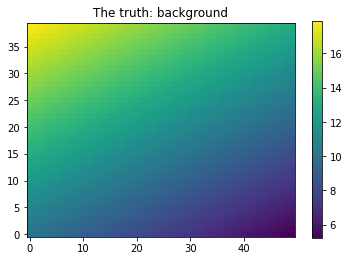

In [9]:
test_bgnd = true_bgnd(x0.flatten(), x1.flatten()).reshape(40, 50)

plt.imshow(test_bgnd, origin='lower')
plt.colorbar()
plt.title("The truth: background");

In [10]:
# Set up the blob
#
true_blob

<Beta2D model instance 'beta2d.true_blob'>

In [11]:
true_blob.xpos = 30.2
true_blob.ypos = 15.8
true_blob.r0 = 7.8
true_blob.alpha = 1.5  # a classical beta=2/3 model

true_blob.ampl = 20

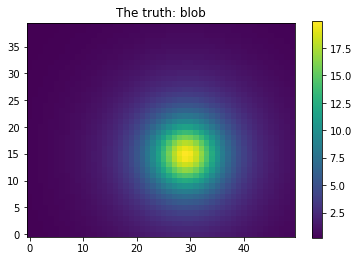

In [12]:
test_blob = true_blob(x0.flatten(), x1.flatten()).reshape(40, 50)

plt.imshow(test_blob, origin='lower')
plt.colorbar()
plt.title("The truth: blob");

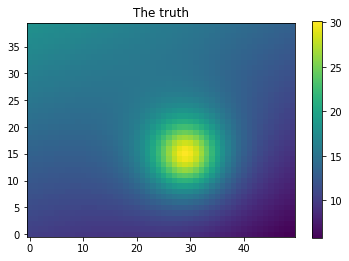

In [13]:
# combining them

test = test_blob + test_bgnd

plt.imshow(test, origin='lower')
plt.colorbar()
plt.title("The truth");

So, let's see if we can add some noise. For this case I am assuming Poisson noise, so I can take advantage of the Sherpa utility routine [poisson_noise](https://sherpa.readthedocs.io/en/latest/overview/api/sherpa.utils.poisson_noise.html):

In [14]:
from sherpa.utils import poisson_noise

test_plus_noise = poisson_noise(test)

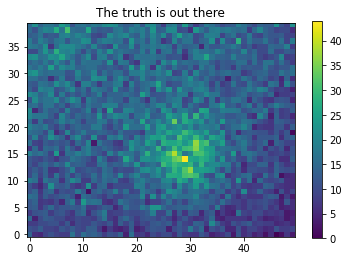

In [15]:
plt.imshow(test_plus_noise, origin='lower')
plt.colorbar()
plt.title("The truth is out there");

# Turning this into a dataset

The [load_arrays](https://cxc.cfa.harvard.edu/sherpa/ahelp/load_arrays.html) command is one of the few Sherpa commands that requires the dataset identifier:

In [16]:
load_arrays(1, x0.flatten(), x1.flatten(), test_plus_noise.flatten(), x0.shape, DataIMG)

In [17]:
get_data()  # we take advantage of the "rich interface" to get nice output in a notebook.

<DataIMG data set instance ''>

In a normal Sherpa or `ipython` session I would use `image_data()` to view this data, butas already mentioned that's not great for a notebook I want to share, so we'll have to "make our own" plots. Fortunately the [get_data_image](https://cxc.cfa.harvard.edu/sherpa/ahelp/get_data_image.html) function and it's relatives let me get the data I need:

In [18]:
def myimage(idata):
    plt.imshow(idata.y, origin='lower')
    plt.colorbar()
    plt.title(idata.name)
    
def myimage_data():
    myimage(get_data_image())

def myimage_model():
    myimage(get_model_image())
    
def myimage_resid():
    myimage(get_resid_image())

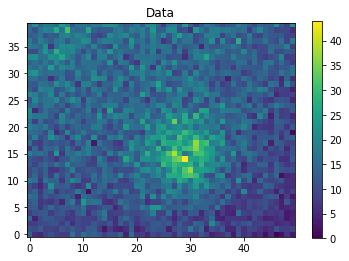

In [19]:
myimage_data()

Let's try fitting the background first, and assume we somehow know the correct functional form!

In [20]:
set_source(polynom2d.bgnd)

In [21]:
get_source()

<Polynom2D model instance 'polynom2d.bgnd'>

In [22]:
# Freee all the parameters and then thaw the ones I want
freeze(bgnd)

thaw(bgnd.c)
thaw(bgnd.cx1)
thaw(bgnd.cy1)

In [23]:
set_stat('cash')  # its Poisson data!

In [24]:
fit()

Dataset               = 1
Method                = levmar
Statistic             = cash
Initial fit statistic = 4000
Final fit statistic   = -93032.8 at function evaluation 25
Data points           = 2000
Degrees of freedom    = 1997
Change in statistic   = 97032.8
   bgnd.c         12.7308      +/- 0.226502    
   bgnd.cy1       0.140146     +/- 0.00734769  
   bgnd.cx1       -0.0598947   +/- 0.00590221  


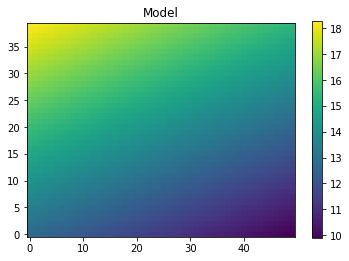

In [25]:
myimage_model()

This is surprisingly (to me) close to the truth, even with the emission from the source included. In reality youre not going to know the functional form of the data!

In [26]:
true_bgnd

<Polynom2D model instance 'polynom2d.true_bgnd'>

Let's add the source:

In [27]:
set_source(beta2d.blob + bgnd)

It can be important to "guide" 2D models to a sensible starting point (and range of parameters). The [guess](https://cxc.cfa.harvard.edu/sherpa/ahelp/guess.html) functino **can** help with this, but the results should be checked as it it not very clever, and could lead you down a rabbit hole not of your choosing!

In [28]:
blob

<Beta2D model instance 'beta2d.blob'>

In [29]:
guess(blob)

In [30]:
blob

<Beta2D model instance 'beta2d.blob'>

Fortunately for this dataset the guess works out quite well, but you can somethimes find parameters like the position or scale factors poorly chosen.

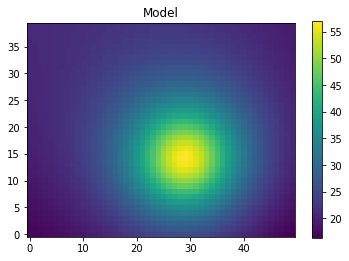

In [31]:
myimage_model()

In [32]:
fit()

Dataset               = 1
Method                = levmar
Statistic             = cash
Initial fit statistic = -77704.4
Final fit statistic   = -94619.5 at function evaluation 64
Data points           = 2000
Degrees of freedom    = 1992
Change in statistic   = 16915.1
   blob.r0        6.35539      +/- 1.32028     
   blob.xpos      30.1259      +/- 0.19911     
   blob.ypos      15.6909      +/- 0.201626    
   blob.ampl      22.6123      +/- 1.62862     
   blob.alpha     1.21176      +/- 0.308574    
   bgnd.c         9.66362      +/- 0.469616    
   bgnd.cy1       0.203777     +/- 0.00788082  
   bgnd.cx1       -0.106371    +/- 0.00637819  


In [33]:
fit()

Dataset               = 1
Method                = levmar
Statistic             = cash
Initial fit statistic = -94619.5
Final fit statistic   = -94619.5 at function evaluation 19
Data points           = 2000
Degrees of freedom    = 1992
Change in statistic   = 4.40117e-06
   blob.r0        6.35671      +/- 1.31925     
   blob.xpos      30.1259      +/- 0.199099    
   blob.ypos      15.6908      +/- 0.201614    
   blob.ampl      22.6108      +/- 1.62941     
   blob.alpha     1.21203      +/- 0.308211    
   bgnd.c         9.66388      +/- 0.469883    
   bgnd.cy1       0.203778     +/- 0.00788075  
   bgnd.cx1       -0.10637     +/- 0.00637818  


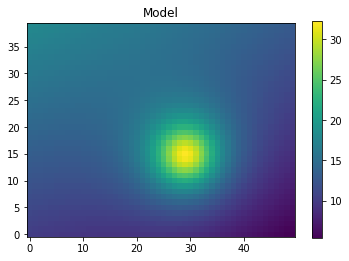

In [34]:
myimage_model()

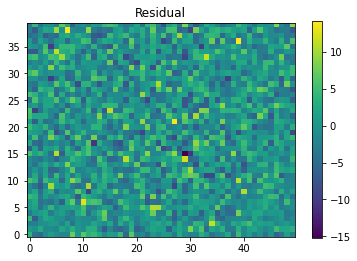

In [35]:
myimage_resid()

So, it seems to have done a good fit.

# Checking the radial profile

Let's check on what the radial profile looks like, using the `sherpa_contrib.profiles` module from the `ciao-contrib` package.

In [36]:
from sherpa_contrib.profiles import *

This module provides a number of routines that act like the `plot_xxx` family of commands but take a 2D dataset, create a radial profile based on the current module (e.g. it's center and ellipcity), and then use this to plot up the data, model, and related commands. Here we can look at the radial profile of the fit and see it looks pretty good (although the asymmetry of the background limits how much you should "trust" this presentation.

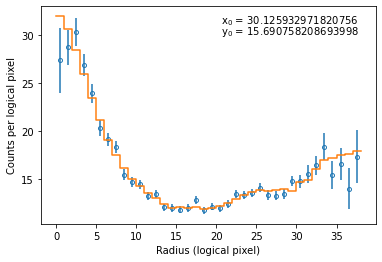

In [37]:
prof_fit()

# What about ignoring regions?

For 1D data we use `notice` and `ignore`, for 2D data we pass in regons using [notice2d](https://cxc.cfa.harvard.edu/sherpa/ahelp/notice2d.html) and [ignore2d](https://cxc.cfa.harvard.edu/sherpa/ahelp/ignore2d.html)$\dagger$.

---

$\dagger$ this is another time that being able to use ds9 is helpful, as you can set up a bunch of regions in ds9 and then use [notice2d_image](https://cxc.cfa.harvard.edu/sherpa/ahelp/notice2d.html_image) or [ignore2d_image](https://cxc.cfa.harvard.edu/sherpa/ahelp/ignore2d_image.html).

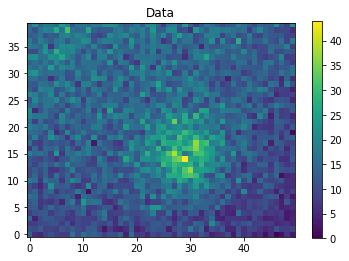

In [38]:
myimage_data()

In [39]:
calc_stat_info()

Dataset               = 1
Statistic             = cash
Fit statistic value   = -94619.5
Data points           = 2000
Degrees of freedom    = 1992


In [40]:
ignore2d('circle(10, 30, 5)')

In [41]:
# Note that the number of data points (and hence the degrees of freedom)
# have reduced now
#
calc_stat_info()

Dataset               = 1
Statistic             = cash
Fit statistic value   = -90265.9
Data points           = 1919
Degrees of freedom    = 1911


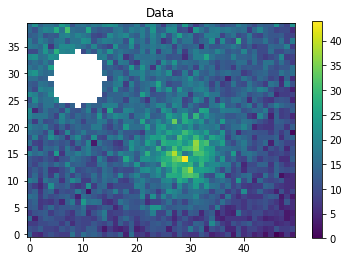

In [42]:
myimage_data()

# How good is the fit?

Using the Cash statistic we have no way to easily determine how "good" the fit is (you'd probably have to do a lot of simulations to get a handle on it).

One alternative is to switch to the [cstat statistic](https://cxc.cfa.harvard.edu/sherpa/ahelp/cstat.html) which comes from XSPEC and is an **approximation** and so should be used carefully.

In [43]:
# Check we are at the "best-fit" location with cash as we've just removed a few bins:
fit()

Dataset               = 1
Method                = levmar
Statistic             = cash
Initial fit statistic = -90265.9
Final fit statistic   = -90265.9 at function evaluation 19
Data points           = 1919
Degrees of freedom    = 1911
Change in statistic   = 0.00352278
   blob.r0        6.37233      +/- 1.3208      
   blob.xpos      30.128       +/- 0.199271    
   blob.ypos      15.6903      +/- 0.201837    
   blob.ampl      22.5968      +/- 1.62399     
   blob.alpha     1.21701      +/- 0.309459    
   bgnd.c         9.67981      +/- 0.468514    
   bgnd.cy1       0.203819     +/- 0.00798543  
   bgnd.cx1       -0.106557    +/- 0.00648164  


In [44]:
set_stat('cstat')

In [45]:
fit()

Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 2039.71
Final fit statistic   = 2039.71 at function evaluation 19
Data points           = 1919
Degrees of freedom    = 1911
Probability [Q-value] = 0.0202992
Reduced statistic     = 1.06735
Change in statistic   = 2.266e-06
   blob.r0        6.37308      +/- 1.31022     
   blob.xpos      30.128       +/- 0.199254    
   blob.ypos      15.6903      +/- 0.201825    
   blob.ampl      22.596       +/- 1.61663     
   blob.alpha     1.21717      +/- 0.306775    
   bgnd.c         9.67997      +/- 0.465706    
   bgnd.cy1       0.203819     +/- 0.0079846   
   bgnd.cx1       -0.106557    +/- 0.00647844  


Note that the `cstat` statistic retirns a reduced statistic (in this case of ~ 1.07, suggesting we've been able to correctly describe the data, but that's not surprising given we know what the "truth" is here):

In [46]:
calc_stat_info()

Dataset               = 1
Statistic             = cstat
Fit statistic value   = 2039.71
Data points           = 1919
Degrees of freedom    = 1911
Probability [Q-value] = 0.0202992
Reduced statistic     = 1.06735
